- 협업필터링 개념
- 협업필터링 종류: 모델기반, 이웃기반, 하이브리드, 딥러닝기반 ... 
- 이웃기반 협업필터링 유사도계산, 아이템기반, 유저기반 -> 유사도; 자카드, 피어슨, 코사인 

In [1]:
import os
import pandas as pd
from math import sqrt
import numpy as np
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


# Dataset

In [2]:
path = '/content/drive/MyDrive/data/movielens'
ratings_df = pd.read_csv(os.path.join(path, 'ratings.csv'), encoding='utf-8')

print(ratings_df.shape)
print(ratings_df.head())

(100836, 4)
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931


In [5]:
train_df, test_df = train_test_split(ratings_df, test_size=0.2, random_state=1234)

print(train_df.shape, test_df.shape)

(80668, 4) (20168, 4)


# Sparse Matrix
  - train_df 의 sparse matrix 만드는 과정
  
  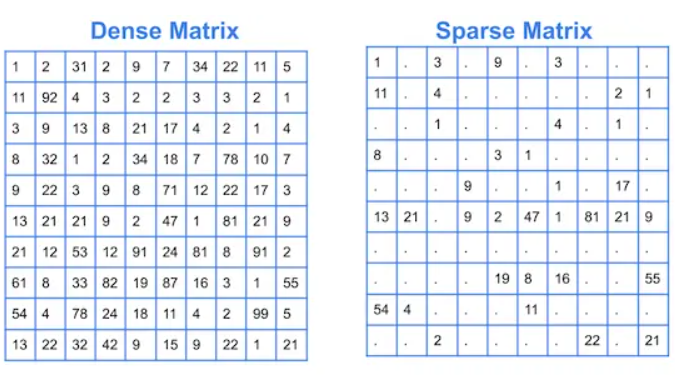

- pandas dataframe의 unstack(계층적 인덱싱)

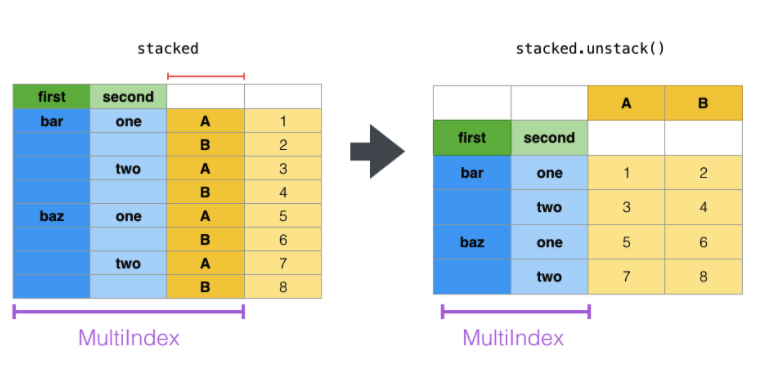

In [7]:
train_df.head()

,userId,movieId,rating,timestamp
95713,600,5943,3.0,1237714356
61560,407,2571,5.0,1424349171
77204,482,8958,4.0,1105397126
93367,599,2322,2.5,1498515283
90892,590,2959,3.5,1258416553
...,...,...,...,...
89460,580,1923,4.0,1167790046
60620,391,2232,4.0,1030826940
34086,232,4344,4.0,1206995838
58067,380,166528,5.0,1493419871


In [10]:
sparse_matrix = train_df.groupby('movieId').apply(lambda x: pd.Series(x['rating'].values, index=x['userId'])).unstack()

In [11]:
sparse_matrix

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,4.0,NaN,4.5,NaN,NaN,NaN,...,4.0,NaN,4.0,3.0,4.0,2.5,NaN,2.5,NaN,5.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,...,NaN,4.0,NaN,NaN,3.5,NaN,NaN,2.0,NaN,NaN
3,4.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193573,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193579,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193581,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 코사인 유사도 활용하기

In [14]:
from sklearn.metrics.pairwise import cosine_similarity

def cossim_matrix(a,b):
  cossim_values = cosine_similarity(a.values, b.values)
  cossim_df = pd.DataFrame(data=cossim_values, columns=a.index.values, index=a.index)

  return cossim_df

# Neighborhood-based 협업필터링 추천점수 계싼하기

# Item-based

In [15]:
item_sparse_matrix = sparse_matrix.fillna(0)
item_sparse_matrix

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,0.0,2.5,0.0,5.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,0.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193573,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193579,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193581,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
item_sparse_matrix.shape

(8938, 610)

In [17]:
item_cossim_df = cossim_matrix(item_sparse_matrix,item_sparse_matrix)
item_cossim_df

,1,2,3,4,5,6,7,8,9,10,...,190219,191005,193565,193567,193571,193573,193579,193581,193587,193609
movieId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.304336,0.267816,0.040259,0.221228,0.266544,0.149392,0.132943,0.182044,0.296838,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.304336,1.000000,0.226138,0.052482,0.154783,0.209716,0.189420,0.068012,0.027945,0.303157,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.267816,0.226138,1.000000,0.000000,0.306435,0.245555,0.368724,0.168267,0.253679,0.178219,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.040259,0.052482,0.000000,1.000000,0.095673,0.068708,0.205962,0.000000,0.000000,0.044835,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.221228,0.154783,0.306435,0.095673,1.000000,0.238683,0.343507,0.204088,0.222925,0.150729,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193573,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
193579,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
193581,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0


In [20]:
# 총 610명의 유저가 총 8938개의 영화에 대해서 어떤 평가를 내렸는지 본다.
userId_grouped = train_df.groupby('userId')
item_prediction_result_df = pd.DataFrame(index=list(userId_grouped.indices.keys()), columns=item_sparse_matrix.index)
item_prediction_result_df

movieId,1,2,3,4,5,6,7,8,9,10,...,190219,191005,193565,193567,193571,193573,193579,193581,193587,193609
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
609,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
for idx, (userId, group) in tqdm(enumerate(userId_grouped)):

  if idx < 1:
  # user가 rating 한 movieId * 전체 movieId
      user_sim = item_cossim_df.loc[group['movieId']] # group['movieId] => 특정 유저의 movieId
      print("user_sim \n",user_sim)
      # user 가 rating한 movidId * 1
      user_rating = group['rating']
      print("user_rating \n",user_rating)
      # 전체 movieId * 1
      sim_sum = user_sim.sum(axis=0)
      print("sim_sum \n",sim_sum)
      # userId의 전체 rating predictions(8938*1)
      pred_ratings = np.matmul(user_sim.T.to_numpy(), user_rating) / (sim_sum+1)
      print("pred_rating \n",pred_ratings)
      item_prediction_result_df.loc[userId] = pred_ratings

  else:
    continue

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


0it [00:00, ?it/s]

user_sim 
            1         2         3       4         5         6         7       \
movieId                                                                       
3062     0.049578  0.073381  0.149305     0.0  0.039272  0.286147  0.054350   
1206     0.234305  0.212832  0.107011     0.0  0.053462  0.314251  0.044478   
2947     0.238091  0.181421  0.074515     0.0  0.093357  0.322563  0.051313   
1029     0.196025  0.238714  0.156893     0.0  0.103104  0.113303  0.067035   
1032     0.231425  0.311296  0.241120     0.0  0.151132  0.164565  0.019316   
...           ...       ...       ...     ...       ...       ...       ...   
2944     0.171684  0.130529  0.166578     0.0  0.058718  0.299938  0.036116   
2028     0.320527  0.209822  0.128420     0.0  0.065782  0.392590  0.106267   
1793     0.068263  0.000000  0.118888     0.0  0.000000  0.077666  0.000000   
1920     0.137896  0.218178  0.166563     0.0  0.029364  0.156891  0.026008   
163      0.173624  0.186364  0.143508    

In [ ]:
for userId, group in tqdm(userId_grouped):
  # user가 rating 한 movieId * 전체 movieId
  user_sim = item_cossim_df.loc[group['movieId']] # group['movieId] => 특정 유저의 movieId
  # user 가 rating한 movidId * 1
  user_rating = group['rating']
  # 전체 movieId * 1
  sim_sum = user_sim.sum(axis=0)

  # userId의 전체 rating predictions(8938*1)
  pred_ratings = np.matmul(user_sim.T.to_numpy(), user_rating) / (sim_sum+1)
  item_prediction_result_df.loc[userId] = pred_ratings

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


  0%|          | 0/610 [00:00<?, ?it/s]

In [23]:
item_prediction_result_df

movieId,1,2,3,4,5,6,7,8,9,10,...,190219,191005,193565,193567,193571,193573,193579,193581,193587,193609
1,4.202787,4.187832,4.176092,3.032719,4.045611,4.240191,3.993299,3.905474,3.702791,4.188552,...,0.979003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.382727
2,3.192613,3.152069,2.461376,0.280903,2.619162,2.975403,1.858767,1.687683,1.092676,3.022348,...,0.387743,1.708851,1.708851,1.708851,1.708851,1.708851,1.708851,1.708851,1.708851,2.326659
3,1.323152,1.204457,1.396351,0.217016,0.819716,1.59889,0.802514,0.755008,0.86708,1.553646,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.48994,3.488045,3.388644,3.150166,3.304884,3.502666,3.317941,2.906289,3.034133,3.416967,...,1.033496,0.505535,0.505535,0.505535,0.505535,0.505535,0.505535,0.505535,0.505535,1.962996
5,3.279163,3.1278,2.999465,2.565822,2.941788,3.168687,3.007926,2.678086,2.276683,3.015567,...,0.391638,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.562705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,3.622904,3.54834,3.4441,3.508062,3.473022,3.630025,3.624999,3.275426,3.262191,3.519265,...,1.833833,1.390511,1.390511,1.390511,1.390511,1.390511,1.390511,1.390511,1.390511,2.99518
607,3.665435,3.654561,3.65215,3.002698,3.505107,3.701121,3.534026,3.350292,3.318345,3.662583,...,0.777542,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.68735
608,3.190528,3.147959,2.957414,2.550022,3.018015,3.259074,2.997039,2.794218,2.789495,3.202343,...,1.959215,0.44408,0.44408,0.44408,0.44408,0.44408,0.44408,0.44408,0.44408,3.461382
609,2.90968,2.859707,2.754801,1.952339,2.631541,2.845162,2.645142,2.415418,2.228029,2.909742,...,0.246588,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.272122


# User-based

In [32]:
user_sparse_matrix = sparse_matrix.fillna(0).transpose()

In [33]:
user_sparse_matrix.head() # user가 기준이므로 transpose -> user 행을 위치하게함

movieId,1,2,3,4,5,6,7,8,9,10,...,190219,191005,193565,193567,193571,193573,193579,193581,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
user_cossim_df = cossim_matrix(user_sparse_matrix, user_sparse_matrix) # 유저끼리의 연관성을 본다.
user_cossim_df

,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.016665,0.070570,0.160438,0.075410,0.087404,0.123664,0.069225,0.037416,0.009900,...,0.056163,0.124896,0.162324,0.050852,0.101583,0.128198,0.240652,0.225897,0.063984,0.095228
2,0.016665,1.000000,0.000000,0.004295,0.020560,0.030996,0.027726,0.000000,0.000000,0.057112,...,0.151666,0.019379,0.006645,0.000000,0.000000,0.028180,0.000000,0.046286,0.033522,0.090288
3,0.070570,0.000000,1.000000,0.002677,0.000000,0.003477,0.000000,0.000000,0.000000,0.000000,...,0.002878,0.002174,0.027609,0.000000,0.000000,0.012090,0.000000,0.023927,0.000000,0.018332
4,0.160438,0.004295,0.002677,1.000000,0.121648,0.093634,0.106495,0.047930,0.000000,0.034281,...,0.065328,0.116656,0.251105,0.056396,0.075940,0.187236,0.102819,0.109515,0.038805,0.086941
5,0.075410,0.020560,0.000000,0.121648,1.000000,0.164390,0.075932,0.302418,0.000000,0.000000,...,0.090020,0.306634,0.103646,0.145354,0.119800,0.071333,0.064705,0.111755,0.159946,0.049236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.128198,0.028180,0.012090,0.187236,0.071333,0.076207,0.159508,0.051044,0.034675,0.066999,...,0.123464,0.083967,0.238107,0.068227,0.110706,1.000000,0.101661,0.218106,0.073027,0.164355
607,0.240652,0.000000,0.000000,0.102819,0.064705,0.121999,0.167129,0.167671,0.000000,0.010033,...,0.064124,0.196274,0.176603,0.111658,0.116814,0.101661,1.000000,0.233010,0.142659,0.114225
608,0.225897,0.046286,0.023927,0.109515,0.111755,0.144931,0.274492,0.166382,0.053714,0.054227,...,0.134966,0.183543,0.198187,0.130758,0.159466,0.218106,0.233010,1.000000,0.107489,0.250085


In [36]:
movieId_grouped = train_df.groupby('movieId')
user_prediction_result_df = pd.DataFrame(index=list(movieId_grouped.indices.keys()), columns=user_sparse_matrix.index)
user_prediction_result_df

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193573,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193579,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193581,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193587,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
for movieId, group in tqdm(movieId_grouped):
    user_sim = user_cossim_df.loc[group['userId']]
    user_rating = group['rating']
    sim_sum = user_sim.sum(axis=0)

    pred_ratings = np.matmul(user_sim.T.to_numpy(), user_rating) / (sim_sum+1)
    user_prediction_result_df.loc[movieId] = pred_ratings

# return user_prediction_result_df.transpose()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


  0%|          | 0/8938 [00:00<?, ?it/s]

In [38]:
user_prediction_result_df

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
1,3.670431,3.348946,2.120998,3.619625,3.761216,3.830873,3.775353,3.797563,3.172106,3.539563,...,3.698942,3.801291,3.664069,3.749287,3.738565,3.614765,3.742089,3.720085,3.704213,3.694626
2,3.018983,2.57281,1.279562,2.937529,3.210439,3.321979,3.109614,3.338104,2.357806,2.828103,...,2.967939,3.329715,2.953535,3.245713,3.158657,3.02316,3.114448,3.116336,3.280792,3.054708
3,3.027028,1.7197,1.266261,2.739661,2.924313,3.326672,2.83467,3.122979,1.68523,2.169252,...,2.421192,3.158458,2.861459,3.081808,2.782756,2.854402,2.987091,3.047977,3.033162,2.701166
4,0.636151,0.146062,0.036718,0.72914,0.957915,1.215909,0.572114,1.165749,0.099046,0.172367,...,0.419299,1.27232,0.834086,1.028533,0.438222,0.709787,0.836006,0.741379,1.008229,0.346251
5,2.334274,1.559442,0.466202,2.102405,2.54943,3.03136,2.350586,2.710275,1.197392,1.729315,...,1.943615,2.828001,2.184871,2.71894,2.29913,2.15327,2.428951,2.483852,2.636362,2.132366
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193573,0.0,0.379994,0.0,0.046584,0.0,0.0,0.036384,0.0,0.0,0.189819,...,0.327665,0.0,0.0,0.0,0.097372,0.051305,0.0,0.021379,0.0,0.336955
193579,0.0,0.332495,0.0,0.040761,0.0,0.0,0.031836,0.0,0.0,0.166092,...,0.286707,0.0,0.0,0.0,0.0852,0.044892,0.0,0.018707,0.0,0.294835
193581,0.0,0.379994,0.0,0.046584,0.0,0.0,0.036384,0.0,0.0,0.189819,...,0.327665,0.0,0.0,0.0,0.097372,0.051305,0.0,0.021379,0.0,0.336955
193587,0.0,0.332495,0.0,0.040761,0.0,0.0,0.031836,0.0,0.0,0.166092,...,0.286707,0.0,0.0,0.0,0.0852,0.044892,0.0,0.018707,0.0,0.294835


In [39]:
# 전체 user가 모든 movieId에 매긴 평점
print(item_prediction_result_df.head())
print(user_prediction_result_df.transpose().head())

movieId    1         2         3         4         5         6         7       \
1        4.202787  4.187832  4.176092  3.032719  4.045611  4.240191  3.993299   
2        3.192613  3.152069  2.461376  0.280903  2.619162  2.975403  1.858767   
3        1.323152  1.204457  1.396351  0.217016  0.819716   1.59889  0.802514   
4         3.48994  3.488045  3.388644  3.150166  3.304884  3.502666  3.317941   
5        3.279163    3.1278  2.999465  2.565822  2.941788  3.168687  3.007926   

movieId    8         9         10      ...    190219    191005    193565  \
1        3.905474  3.702791  4.188552  ...  0.979003       0.0       0.0   
2        1.687683  1.092676  3.022348  ...  0.387743  1.708851  1.708851   
3        0.755008   0.86708  1.553646  ...       0.0       0.0       0.0   
4        2.906289  3.034133  3.416967  ...  1.033496  0.505535  0.505535   
5        2.678086  2.276683  3.015567  ...  0.391638       0.0       0.0   

movieId    193567    193571    193573    193579    19358

# RSME로 추천시스템 성능 평가하기

In [40]:
test_df.head()

,userId,movieId,rating,timestamp
99731,610,3527,5.0,1479545223
97583,606,1250,3.5,1171376891
38197,262,213,5.0,840310907
11474,68,69406,3.0,1261622505
34105,232,4728,3.0,1218166950


In [85]:
# train_df 와 test_df에 동시에 평점이 있어야 평가가 가능하다.
def evaluate(test_df, prediction_result_df):
  groups_with_movie_ids = test_df.groupby(by='movieId')
  groups_with_user_ids = test_df.groupby(by='userId')
  intersection_movie_ids = sorted(list(set(list(prediction_result_df.columns)).intersection(set(list(groups_with_movie_ids.indices.keys())))))
  intersection_user_ids = sorted(list(set(list(prediction_result_df.index)).intersection(set(groups_with_user_ids.indices.keys()))))

  print(len(intersection_movie_ids))
  print(len(intersection_user_ids))

  compressed_prediction_df = prediction_result_df.loc[intersection_user_ids][intersection_movie_ids]
  # compressed_prediction_df

  # test_df에 대해서 RMSE 계산
  grouped = test_df.groupby(by='userId')
  result_df = pd.DataFrame(columns=['rmse'])
  for userId, group in tqdm(grouped):
      if userId in intersection_user_ids:
          pred_ratings = compressed_prediction_df.loc[userId][compressed_prediction_df.loc[userId].index.intersection(list(group['movieId'].values))]
          pred_ratings = pred_ratings.to_frame(name='rating').reset_index().rename(columns={'index':'movieId','rating':'pred_rating'})
        
          actual_ratings = group[['rating', 'movieId']].rename(columns={'rating':'actual_rating'})
          

          final_df = pd.merge(actual_ratings, pred_ratings, how='inner', on=['movieId'])
          final_df = final_df.round(4) # 반올림

          # if not final_df.empty:
          #     rmse = sqrt(mean_squared_error(final_df['rating_actual'], final_df['rating_pred']))
          #     result_df.loc[userId] = rmse
          #     # print(userId, rmse)
    
  return final_df


In [88]:
user_prediction_result_df = user_prediction_result_df.transpose()
evaluate(test_df, user_prediction_result_df)


4385
610


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/610 [00:00<?, ?it/s]

,actual_rating,movieId,pred_rating
0,5.0,3527,3.285668
1,3.5,84772,2.211593
2,3.5,103141,2.835437
3,4.0,81132,0.450808
4,4.5,130634,1.022444
...,...,...,...
218,4.0,106100,2.868226
219,4.0,111759,3.513955
220,1.0,4852,0.202402
221,3.0,2628,2.937769


In [87]:
evaluate(test_df, item_prediction_result_df)

4385
610


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/610 [00:00<?, ?it/s]

,actual_rating,movieId,pred_rating
0,5.0,3527,3.797414
1,3.5,84772,3.730651
2,3.5,103141,3.689697
3,4.0,81132,3.334023
4,4.5,130634,3.451202
...,...,...,...
218,4.0,106100,3.729685
219,4.0,111759,3.758423
220,1.0,4852,3.648878
221,3.0,2628,3.812378


In [47]:
result_df = evaluate(test_df, item_prediction_result_df)
print(result_df)
print(f"RMSE: {sqrt(mean_squared_error(result_df['actual_rating'].values, result_df['pred_rating'].values))}")

4385
610


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/610 [00:00<?, ?it/s]

     actual_rating  movieId pred_rating
0              5.0     3527    3.797414
1              3.5    84772    3.730651
2              3.5   103141    3.689697
3              4.0    81132    3.334023
4              4.5   130634    3.451202
..             ...      ...         ...
218            4.0   106100    3.729685
219            4.0   111759    3.758423
220            1.0     4852    3.648878
221            3.0     2628    3.812378
222            5.0     1953    3.866463

[223 rows x 3 columns]
RMSE: 0.8145193961484049


In [89]:
result_df = evaluate(test_df, user_prediction_result_df)
print(result_df)
print(f"RMSE: {sqrt(mean_squared_error(result_df['actual_rating'].values, result_df['pred_rating'].values))}")

4385
610


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/610 [00:00<?, ?it/s]

     actual_rating  movieId pred_rating
0              5.0     3527    3.285668
1              3.5    84772    2.211593
2              3.5   103141    2.835437
3              4.0    81132    0.450808
4              4.5   130634    1.022444
..             ...      ...         ...
218            4.0   106100    2.868226
219            4.0   111759    3.513955
220            1.0     4852    0.202402
221            3.0     2628    2.937769
222            5.0     1953    3.172221

[223 rows x 3 columns]
RMSE: 1.6949489761800296
